<a href="https://colab.research.google.com/github/AdrianMartinezCode/python_machine_learning_collabs/blob/main/hotel_booking_ml_no_plots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

# Replace 'path_to_your_file.csv' with the actual path of your CSV file
file_path = '/content/drive/My Drive/Colab Notebooks/exercises/booking.csv'
df = pd.read_csv(file_path)

# Now you can work with the dataframe 'df'


Official page where I extracted the dataset:
https://www.kaggle.com/datasets/youssefaboelwafa/hotel-booking-cancellation-prediction/data

**Text**:
Welcome to the Hotel Booking Cancellation Prediction dataset, a comprehensive collection of data aimed at predicting hotel booking cancellations. This dataset is ideal for data scientists, researchers, and machine learning enthusiasts seeking to develop models that can accurately forecast the likelihood of hotel reservation cancellations.

Dataset Overview:
This dataset comprises a diverse range of features, including booking details, customer information, and reservation specifics. The information has been meticulously gathered from real-world hotel booking scenarios, ensuring authenticity and relevance for predictive modeling.

**Booking_ID**:
Unique identifier for each booking

**number of adults**: Number of adults included in the booking

**number of children**: Number of children included in the booking

**number of weekend nights**: Number of weekend nights included in the booking

**number of week nights**: Number of week nights included in the booking

**type of meal**: Type of meal included in the booking

**car parking space**: Indicates whether a car parking space was requested or included in the booking

**room type**: Type of room booked

**lead time**: Number of days between the booking date and the arrival date

**market segment type**: Type of market segment associated with the booking

In this sheet we want to predict if the reservation will be cancelled in any moment or not.

In [ ]:
print(df.columns)

In [ ]:
print(df.head(3))

# PREPROCESSING


In [ ]:
for c in df.columns:
  print(f"Unique values in '{c}': {df[c].unique()}")

In [ ]:
# Iterate over each column and print the count of missing values
for column in df.columns:
    missing_values = df[column].isnull().sum()
    print(f"Number of missing values in '{column}': {missing_values}")

No missing values. Let's transform the different fields to numeric.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def plot_column(column, df):
  if pd.api.types.is_numeric_dtype(df[column]):
    # Histogram
    sns.histplot(df[column], kde=True)
    plt.title(f'Histogram of {column}')
    plt.show()

    # Box Plot
    sns.boxplot(x=df[column])
    plt.title(f'Box Plot of {column}')
    plt.show()

  # If the column is non-numeric
  else:
      # Bar Chart of value counts
      df[column].value_counts().plot(kind='bar')
      plt.title(f'Bar Chart of {column}')
      plt.ylabel('Frequency')
      plt.show()

In [ ]:
# Loop through each column
for column in df.columns:
    # Check if the column is numeric
    if not column == 'Booking_ID' and not column == 'date of reservation':
      plot_column(column, df)


Transformation of categorical values into numerical features.

We use one hot encoding instead of using a bijective function because if we assign a one number inside a range in a one variable we are making a certain order which can lead to confuse the model.

It is a better practice to use the one hot encoding and increase the dimensionality of the overall feature vectors.

This is not valid for all categorical variables, for example the number of children is a categorical variable and follows a certain order, it is more probable that the reservation will includes 2 children than 10.

In [ ]:
# type of meal into one hot encoding
type_of_meal_encoded = pd.get_dummies(df['type of meal'], prefix='type of meal')
print(type_of_meal_encoded)
df = df.join(type_of_meal_encoded)

In [ ]:
# room_type into one hot encoding
room_type_encoded = pd.get_dummies(df['room type'], prefix='room type')
print(room_type_encoded)
df = df.join(room_type_encoded)

In [ ]:
# market segment type into one hot encoding
market_segment_type_encoded = pd.get_dummies(df['market segment type'], prefix='market segment type')
print(market_segment_type_encoded)
df = df.join(market_segment_type_encoded)

In [ ]:
# Create a mapping from categories to integers
booking_status_map = {category: idx for idx, category in enumerate(df['booking status'].unique())}
df['booking status encoded'] = df['booking status'].map(booking_status_map)

In [ ]:
# removal of non relevant columns to fit the model
del df['Booking_ID']
del df['type of meal']
del df['room type']
del df['market segment type']
del df['booking status']

# date of reservation won't provide any relevant information to the model,
# maybe the density of reservations in time, it's hard to map to any resevration
# function instead of dates, to simplify we will delete this variabel
del df['date of reservation']

In [ ]:
plot_column('average price', df)

We can see that the average price has too many zeroes, we can try to predict these...

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Splitting the data into rows with zeros and without zeros
df_with_zeros = df[df['average price'] == 0]
df_without_zeros = df[df['average price'] != 0]

# Splitting into features (X) and target (y)
X = df_without_zeros.drop('average price', axis=1)
y = df_without_zeros['average price']

# Train-Test Split for model validation (optional)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating and training the regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predicting the zero values
predicted_values = model.predict(df_with_zeros.drop('average price', axis=1))

# Replace zeros in the original DataFrame
df.loc[df['average price'] == 0, 'average price'] = predicted_values

In [ ]:
# Check again the average price, we can see that the zeroes has been changed for more estimated values
plot_column('average price', df)

# FEATURE SELECTION
Let's analyze the

In [ ]:
from sklearn.feature_selection import VarianceThreshold

vt = VarianceThreshold(threshold=0.5)
vt.fit(df)

# find the features that meet the variance threshold
mask = vt.get_support()
chosen_features = list(df.loc[:, mask].columns)
removed_features = [feature for feature in df.columns if feature not in chosen_features]

# show the chosen and removed features
print('Chosen features: {}'.format(chosen_features))
print('Removed features: {}'.format(removed_features))

Chosen features: ['number of weekend nights', 'number of week nights', 'lead time', 'P-not-C', 'average price', 'special requests']
Removed features: ['number of adults', 'number of children', 'car parking space', 'repeated', 'P-C', 'type of meal_Meal Plan 1', 'type of meal_Meal Plan 2', 'type of meal_Meal Plan 3', 'type of meal_Not Selected', 'room type_Room_Type 1', 'room type_Room_Type 2', 'room type_Room_Type 3', 'room type_Room_Type 4', 'room type_Room_Type 5', 'room type_Room_Type 6', 'room type_Room_Type 7', 'market segment type_Aviation', 'market segment type_Complementary', 'market segment type_Corporate', 'market segment type_Offline', 'market segment type_Online', 'booking status encoded']


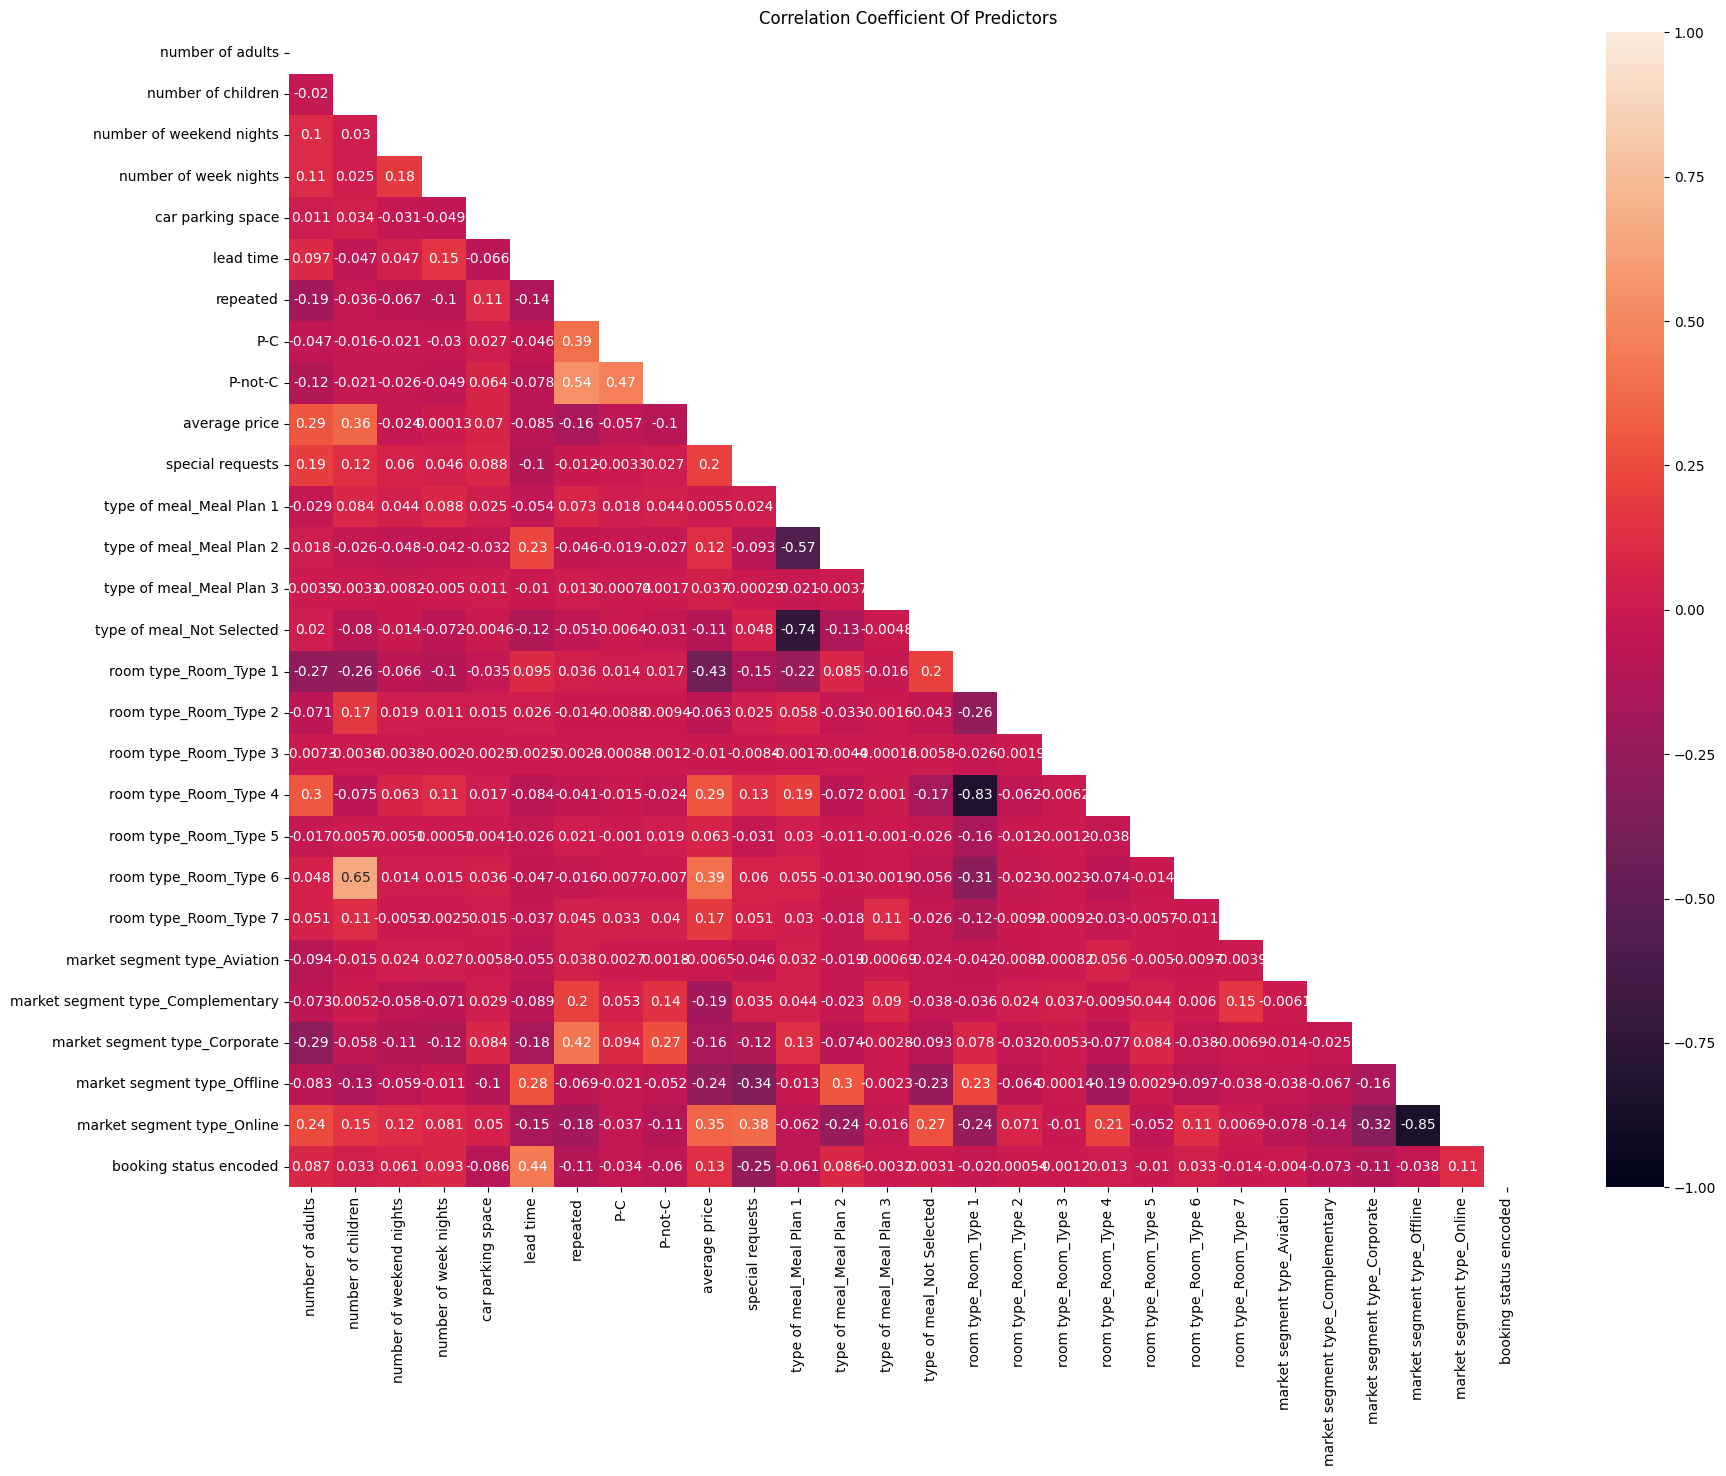

In [ ]:
import numpy as np

# plot heatmap
plt.figure(figsize=(20,15))


# Generate a mask to onlyshow the bottom triangle
mask = np.triu(np.ones_like(df.corr(), dtype=bool))

# generate heatmap
sns.heatmap(df.corr(), annot=True, mask=mask, vmin=-1, vmax=1)
plt.title('Correlation Coefficient Of Predictors')
plt.show()

# Training and selection of the model
We've preprocessed the data and cleaned the different variables.
The next step is start to train different models and evaluate each of them.
The steps for each model will be:
- Split the train data into 5 folds.
- Choose a set of values for the hyperparameters of the model.
- Train the model for each element from the set.
- Evaluate each fold:
  1. Confusion matrix
  2. Precision/Recall
  3. Accuracy
  4. Cost-Sensitive Accuracy
  5. Area under the ROC Curve (AUC)
- Choose the best set of hyperparameters.

When we have all the models trained with a good hyperparameter selection for each, we can try to compare all the results and choose the definitive model.

Models that will be utilized:
- Linear Regression
- Logistic Regression
- Decission Tree Learning
- Support Vector Machine
- Neural Network

NOTE: we will evalute each execution with a reduced dimensionality plot, that means that will not be accurated but is done just to see how the boundary line is positionated.

In [ ]:
def print_scores(scores_arrays):
  for t in scores_arrays:
    print(t)

In [ ]:
from sklearn.model_selection import train_test_split

def split_train_test_validation(df):
  # Splitting into training (70%) and a temporary set (30%)
  train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)

  # Splitting the temporary set into validation and test sets (50% each of temp_df)
  validation_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

  # Now, train_df, validation_df, and test_df are 70%, 15%, and 15% of the original dataset respectively.
  return [train_df, test_df, validation_df]

In [ ]:
import pandas as pd
import numpy as np

def slice_n(df, slices):
  # Shuffle the DataFrame using sample with frac=1
  shuffled_df = df.sample(frac=1, random_state=42)

  # Calculate the size of each slice
  slice_size = len(shuffled_df) // slices

  # Create a list to store each slice
  slices_list = []

  # Split the DataFrame into n slices
  for i in range(slices):
      start = i * slice_size
      if i == slices - 1:
          # Last slice takes the remainder of the DataFrame
          end = len(shuffled_df)
      else:
          end = (i + 1) * slice_size
      slices_list.append(shuffled_df.iloc[start:end])

  # slices[0], slices[1], ..., slices[n-1] are your n slices
  return slices_list

In [ ]:
def extract_features_X_y(df):
  X = df[df.columns]  # Example feature columns
  del X['booking status encoded']
  y = df['booking status encoded']
  return [X, y]

In [ ]:
def map_float_predictions(predictions):
  # Define the threshold
  threshold = 0.5

  # Apply the threshold to each prediction
  binary_predictions = (predictions > threshold).astype(int)

  return binary_predictions

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Let's try to create an score to be able to choose lately the best
# resulted option, so, the less value scored will be the best option
# because will have the less quantity of errors.

# Assign weights to be able to make more relevant some metrics than others.
#mse_ratio = .7
#r2_ratio = .4 # Normally it is higher than mse
#accuracy_ratio = 1
#auc_score_ratio = .8
#cost_sensitive_accuracy_ratio = .6


def evaluate_results(y, predictions, basic_error_eval=False):

  score = {}

  mse = mean_squared_error(y, predictions)
  r2 = r2_score(y, predictions)
  print(f"Mean Squared Error: {mse}")
  print(f"R-squared: {r2}")

  score["mse"] = mse
  score["r2"] = r2

  #score = score + mse*mse_ratio + r2*r2_ratio

  predictions = map_float_predictions(predictions)

  accuracy = accuracy_score(y, predictions)
  print(f"Accuracy: {accuracy}")

  score["accuracy"] = accuracy
  #score = score + (1 - accuracy)*accuracy_ratio

  if not basic_error_eval:
    report = classification_report(y, predictions)
    conf_matrix = confusion_matrix(y, predictions)
    print("Classification Report:")
    print(report)
    print("Confusion Matrix:")
    print(conf_matrix)

    # auc = roc_auc_score(y, predictions)
    # print(f"Area Under the ROC Curve (AUC): {auc}")
    # Compute the ROC Curve
    fpr, tpr, thresholds = roc_curve(y, predictions)

    # Compute the AUC score
    auc_score = roc_auc_score(y, predictions)
    print(f"AUC: {auc_score}")
    score["auc"] = auc_score

    # Plot the ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], color='darkgrey', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    #score = score + (1 - auc_score)*auc_score_ratio

    # Define the cost of a false positive and false negative
    cost_fp = 1  # Example cost
    cost_fn = 1  # Example cost

    # Assuming you have the actual labels (y_test) and predictions (y_pred)

    # Calculate confusion matrix
    tn, fp, fn, tp = conf_matrix.ravel()
    # tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    # Calculate the total cost
    total_cost = fp * cost_fp + fn * cost_fn

    # Calculate cost-sensitive accuracy
    total_samples = len(y)
    normal_accuracy = (tp + tn) / total_samples
    cost_sensitive_accuracy = normal_accuracy - (total_cost / total_samples)

    print(f"Cost-Sensitive Accuracy: {cost_sensitive_accuracy}")

    #score = score + (1 - cost_sensitive_accuracy)*cost_sensitive_accuracy_ratio
    score["cost-sensitive-acc"] = cost_sensitive_accuracy
  return score

# Linear Regression

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA

def train_linear_regression(df):
  [df_train, df_test, df_validation] = split_train_test_validation(df)

  [X_train, y_train] = extract_features_X_y(df_train)
  [X_test, y_test] = extract_features_X_y(df_test)
  [X_validation, y_validation] = extract_features_X_y(df_validation)

  model = LinearRegression()
  model.fit(X_train, y_train)

  predictions = model.predict(X_test)

  score = evaluate_results(y_test, predictions)

  # Apply PCA for dimensionality reduction
  pca = PCA(n_components=2)
  X_pca = pca.fit_transform(X_train)

  # Fit linear regression on the reduced data
  model = LinearRegression()
  model.fit(X_pca, y_train)

  # Plotting
  plt.figure(figsize=(8, 6))
  plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='viridis', edgecolor='k', s=50)


  # Creating a meshgrid to plot the regression plane
  xx, yy = np.meshgrid(np.linspace(X_pca[:, 0].min(), X_pca[:, 0].max(), 30),
                      np.linspace(X_pca[:, 1].min(), X_pca[:, 1].max(), 30))

  # Predicting on the meshgrid
  Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)


  # Plotting the regression plane
  plt.contourf(xx, yy, Z, alpha=0.5, cmap='viridis')
  plt.colorbar(label='Target')
  plt.xlabel('Principal Component 1')
  plt.ylabel('Principal Component 2')
  plt.title('Linear Regression Fit with PCA')
  plt.show()

  return score

In [ ]:
# There aren't hyperparameters in linear regression because it is not learned with stochastic gradient descent.
# https://github.com/scikit-learn/scikit-learn/issues/12572
score = train_linear_regression(df)
print(f"Score for Linear Regression {score}")

# Logistic Regression

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


def train_logistic_regression(df, penalty='l2', C=1.0, solver='lbfgs', max_iter=100):

  [df_train, df_test, df_validation] = split_train_test_validation(df)

  [X_train, y_train] = extract_features_X_y(df_train)
  [X_test, y_test] = extract_features_X_y(df_test)
  [X_validation, y_validation] = extract_features_X_y(df_validation)

  # Since we have problems to converge the function to a reasonable approximation
  # with the logistic regression, we opted to use an standard scaler for this
  # model to make easier to the model to converge
  pipe = make_pipeline(StandardScaler(), LogisticRegression(penalty=penalty, C=C, solver=solver, max_iter=max_iter))
  pipe.fit(X_train, y_train)
  predictions = pipe.predict(X_test)

  score = evaluate_results(y_test, predictions)

  # Exmple reducing the dimensionality of the features to be able to plot
  # the boundary line of the model.

  # Step 1: Apply PCA for dimensionality reduction
  pca = PCA(n_components=2)
  X_pca = pca.fit_transform(X_train)
  # Fit logistic regression on the reduced data
  model_pca = LogisticRegression()
  model_pca.fit(X_pca, y_train)
  # Step 2: Plot the decision boundary
  # Create a mesh to plot in 2D
  x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
  y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
  xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))
  # Predict probabilities on the mesh
  Z = model_pca.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
  Z = Z.reshape(xx.shape)
  # Plotting decision boundary
  plt.contourf(xx, yy, Z, levels=[0, 0.5, 1], cmap='RdBu', alpha=0.8)
  plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='RdBu', edgecolors='k')

  plt.xlabel('PCA Feature 1')
  plt.ylabel('PCA Feature 2')
  plt.title('Logistic Regression Decision Boundary with PCA')
  plt.show()
  return score

In [ ]:
C_values = [x / 10.0 for x in range(1, 10, 2)]
max_iter_values = range(50, 150, 50)
solver_penalty_values = [
    ['lbfgs', 'l2'],
    ['lbfgs', None],
    ['liblinear', 'l1'],
    ['liblinear', 'l2'],
    ['newton-cg', 'l2'],
    ['newton-cg', None],
    ['newton-cholesky', 'l2'],
    ['newton-cholesky', None],
    ['sag', 'l2'],
    # ['saga', 'elasticnet'], <-
    ['saga', 'l1'],
    ['saga', 'l2'],
    ['saga', None],
]

scores_logistic_regression = []
for solver, penalty in solver_penalty_values:
  for C in C_values:
    for max_iter in max_iter_values:
      print(f'Executing logistic regression with: {solver}, {penalty}, {C}, {max_iter}')
      score = train_logistic_regression(df, penalty, C, solver, max_iter)
      scores_logistic_regression.append([score, solver, penalty, C, max_iter])

print(scores_logistic_regression)
# slices = slice_n(df, 5)
# for slice in slices:
#   train_logistic_regression(slice)

# Decission Tree Learning

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

def train_decision_tree(df, criterion='gini', splitter='best', max_features=None, class_weight=None):
  [df_train, df_test, df_validation] = split_train_test_validation(df)

  [X_train, y_train] = extract_features_X_y(df_train)
  [X_test, y_test] = extract_features_X_y(df_test)
  [X_validation, y_validation] = extract_features_X_y(df_validation)

  # Create the Decision Tree model
  model = DecisionTreeClassifier(random_state=42, criterion=criterion, splitter=splitter, max_features=max_features, class_weight=class_weight)

  # Train the model
  model.fit(X_train, y_train)

  # Make predictions
  predictions = model.predict(X_test)

  score = evaluate_results(y_test, predictions)

  # Plot the first 3 levels from the decision tree
  # Plot the decision tree
  plt.figure(figsize=(14, 10))  # Adjust the size as needed
  plot_tree(model, max_depth=2, filled=True, feature_names=X_train.columns, class_names=True, rounded=True)
  plt.show()

  return score

In [ ]:
criterion_values = ['gini', 'entropy', 'log_loss']
splitter_values = ['best', 'random']
max_features_values = ['auto', 'sqrt', 'log2', None] # here we can add floats and integers
class_weight_values = ['balanced', None] # here we can assign weights to each feature to make some features more important than others

scores_decission_tree = []
for criterion in criterion_values:
  for splitter in splitter_values:
    for max_features in max_features_values:
      for class_weight in class_weight_values:
        print(f'Executing decission tree with: {criterion}, {splitter}, {max_features}, {class_weight}')
        score = train_decision_tree(df, criterion, splitter, max_features, class_weight)
        scores_decission_tree.append([score, criterion, splitter, max_features, class_weight])

print(scores_decission_tree)

In [ ]:
print_scores(scores_decission_tree)

# Support Vector Machine

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

def train_svm(df, kernel='linear', plots=True, basic_error_eval=False, C=1, gamma='scale'):
  [df_train, df_test, df_validation] = split_train_test_validation(df)

  [X_train, y_train] = extract_features_X_y(df_train)
  [X_test, y_test] = extract_features_X_y(df_test)
  [X_validation, y_validation] = extract_features_X_y(df_validation)

  # Create the SVM model
  model = SVC(random_state=42, kernel=kernel, C=C, gamma=gamma)
  model.fit(X_train, y_train)

  # Make predictions
  predictions = model.predict(X_test)

  print(f'--- Results for SVM: kernel={kernel}, C={C}, gamma={gamma}')

  score = evaluate_results(y_test, predictions, basic_error_eval)
  if plots:

    # Apply PCA for dimensionality reduction
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_train)

    # Fit SVM on the reduced data
    svm_model = SVC(random_state=42, kernel=kernel, C=C, gamma=gamma)
    svm_model.fit(X_pca, y_train)

    # Create a mesh grid for plotting
    x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
    y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

    # Predict on the mesh grid
    Z = svm_model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plotting
    plt.contourf(xx, yy, Z, alpha=0.8, cmap='viridis')
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, s=50, edgecolor='k', cmap='viridis')


    # Highlight the support vectors
    plt.scatter(svm_model.support_vectors_[:, 0], svm_model.support_vectors_[:, 1],
                s=100, facecolors='none', edgecolors='k')

    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('SVM Decision Boundary with PCA')
    plt.show()

  return score


In [ ]:
[n1, n2, n3, n4] = slice_n(df, 4)
# train_svm(n1, 'linear')
# train_svm(n2, 'poly')
# train_svm(n3, 'rbf')
# train_svm(n4, 'sigmoid')

kernel=linear has the optimal results for the default params c=1 and gamma='scale', but is the most expensive kernel in terms of time because it has as a complexity O(n^2), let's try to combine some values of hyperparameters using cross-validation

In [ ]:
# TODO

kernels = ['poly', 'rbf', 'sigmoid']
gammas = ['scale', 'auto'] + [x / 10.0 for x in range(1, 5, 1)]

ns = slice_n(df, 10)

scores_svm = []
for C in range(1, 5, 1):
  for gamma in gammas:
    for kernel in kernels:
      scores_svm.append([train_svm(ns[0], kernel, False, True, C, gamma), C, gamma, kernel])

# Neural networks

In [ ]:
# Install graphviz and pydot
!apt-get -qq install -y graphviz && pip install -q pydot
import pydot

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import plot_model
from IPython.display import display, Image

import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from tensorflow.keras.models import Model

from mlxtend.plotting import plot_decision_regions

def train_neural_network(df, seed=42):
  np.random.seed(seed)
  tf.random.set_seed(seed)
  tf.keras.utils.set_random_seed(seed)

  [df_train, df_test, df_validation] = split_train_test_validation(df)

  [X_train, y_train] = extract_features_X_y(df_train)
  [X_test, y_test] = extract_features_X_y(df_test)
  [X_validation, y_validation] = extract_features_X_y(df_validation)

  scaler = StandardScaler()
  X_train_tr = scaler.fit_transform(X_train)
  X_test_tr = scaler.transform(X_test)

  # Create the neural network model
  model = tf.keras.models.Sequential([
      tf.keras.layers.Dense(20, activation='relu', input_shape=(X_train_tr.shape[1],)),
      tf.keras.layers.Dense(50, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  # Compile the model
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

  # Train the model
  model.fit(X_train_tr, y_train, epochs=10, batch_size=32, validation_split=0.2)

  # Evaluate the model
  loss, accuracy = model.evaluate(X_test_tr, y_test)
  print(f"Test Accuracy: {accuracy}")
  print(f"SEED: {seed}")

  # print(model.summary())


  # Generate the plot
  plot_file_path = 'model_plot.png'
  plot_model(model, to_file=plot_file_path, show_shapes=True, show_layer_names=True)

  # Display the image
  display(Image(filename=plot_file_path))

  # model_file = 'my_model.h5'
  # model.save(model_file)

  subset_size = 1000  # Adjust this based on your dataset size
  indices = np.random.choice(X_train.index, subset_size, replace=False)
  X_subset = X_train.loc[indices]
  y_subset = y_train[indices]

  # Reduce X to two dimensions using PCA
  pca = PCA(n_components=2, random_state=seed)
  X_reduced = pca.fit_transform(X_train_tr)

  # Create a meshgrid in the reduced space
  x_min, x_max = X_reduced[:, 0].min() - 1, X_reduced[:, 0].max() + 1
  y_min, y_max = X_reduced[:, 1].min() - 1, X_reduced[:, 1].max() + 1
  xx, yy = np.meshgrid(np.linspace(x_min, x_max, num=300),
                      np.linspace(y_min, y_max, num=300))

  # Pad the meshgrid points to match the original feature space
  num_original_features = X_train_tr.shape[1]
  mesh_points_padded = np.c_[xx.ravel(), yy.ravel(), np.zeros((len(xx.ravel()), num_original_features - 2))]

  # Predict the classes for the padded meshgrid points using the original model
  Z = model.predict(mesh_points_padded)
  Z = (Z > 0.5).astype(int).reshape(xx.shape)

  # print(Z)

  # Plot the decision boundary in the PCA reduced feature space
  plt.contourf(xx, yy, Z, alpha=0.3)
  # plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_train, edgecolor='k')
  plt.title('Decision Boundary in PCA Reduced Feature Space')
  plt.xlabel('PCA Component 1')
  plt.ylabel('PCA Component 2')
  plt.show()

  plt.contourf(xx, yy, Z, alpha=0.3)
  plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_train, edgecolor='k')
  plt.title('Decision Boundary in PCA Reduced Feature Space')
  plt.xlabel('PCA Component 1')
  plt.ylabel('PCA Component 2')
  plt.show()


In [ ]:
# for seed in range(1, 2000, 100):
#   train_neural_network(df, seed)

# After some iterations, we will use the seed 401, which has as accuracy 0.832,
# and we can see the decision boundary clearly in two dimensions, this plot representation
# is not accurated because when we reduce the dimensionality we are loosing resolution
# but it is useful to see how the decision boundary is shown, we can see that
# is not linear.
train_neural_network(df, 401)

In [ ]:
train_neural_network(df, 401)